# 라이브러리 로드

In [1]:
%config Completer.use_jedi = False
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import warnings
warnings.filterwarnings('ignore')

# 모델 생성
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report


# 노트북 안에 그래프를 그리기 위해
%matplotlib inline

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'


In [2]:
def churn_prediction(df, web_df):
    # 범주형 컬럼 One-Hot Encoding
    encoding_df = pd.get_dummies(df, columns=['Membership', 'Contract'])

    # 학습/테스트셋 분리
    y_target = encoding_df['Churn Value']
    X_data = encoding_df.drop(['Churn Value'], axis=1, inplace=False)

    X_train, X_test, y_train, y_test = train_test_split(X_data, y_target, test_size=0.2, random_state=156)

    # 학습 데이터셋(수치형 컬럼) 정규화
    ## Initialize variable
    X_train_origin, X_test_origin, y_train_origin, y_test_origin = X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy()

    ## Numeric Only
    Numeric_column_list = []
    for i in range(len(X_data.columns)):
        if X_data[X_data.columns[i]].dtype == 'float64' or X_data[X_data.columns[i]].dtype == 'int64':
            Numeric_column_list.append(X_data.columns[i])

    numeric_train_data, numeric_test_data = X_train[Numeric_column_list], X_test[Numeric_column_list]

    scaler = MinMaxScaler()

    X_train[Numeric_column_list] = scaler.fit_transform(numeric_train_data)
    X_test[Numeric_column_list] = scaler.transform(numeric_test_data)

    # 선정한 모델로 학습
    best_model = SGDClassifier(random_state=42, alpha=0.001, loss='modified_huber',
                               max_iter=100, penalty='l1', tol=1e-05)

    best_model.fit(X_train, y_train)


    # 예측 결과 저장
    
    result_df = web_df.copy()
    result_df = result_df.iloc[:, 1:]
    
    ## 범주형 컬럼 One-Hot Encoding
    encoding_test_data = pd.get_dummies(result_df, columns=['Membership', 'Contract'])
    
    ## 정규화 (Numeric Only)
    test_Numeric_column_list = []
    for i in range(len(encoding_test_data.columns)):
        if encoding_test_data[encoding_test_data.columns[i]].dtype == 'float64' or encoding_test_data[encoding_test_data.columns[i]].dtype == 'int64':
            test_Numeric_column_list.append(encoding_test_data.columns[i])
            
    test_numeric_data = encoding_test_data[test_Numeric_column_list]

    scaler = MinMaxScaler()

    encoding_test_data[test_Numeric_column_list] = scaler.fit_transform(test_numeric_data)
    final_test_data = encoding_test_data
            
    
    # 최적의 모델을 사용하여 테스트 데이터의 클래스 확률을 예측합니다.
    predicted_probabilities = best_model.predict_proba(final_test_data)

    # 결과를 데이터프레임에 추가
    web_df['이탈확률'] = predicted_probabilities[:, 1]*100  # 클래스 1의 확률을 선택


    
    return web_df

# 학습에 이용할 데이터 로드

In [3]:
df = pd.read_excel("Churn.xlsx")
df.head()

,Age,Number of Dependents,Membership,Satisfaction Score,Tech services,Streaming services,Combined Product,Contract,Tenure in Months,Monthly Charge,Total Revenue,Churn Value
0,78,0,None,3,1,1,2,Month-to-Month,1,39.65,59.65,1
1,74,1,Offer E,3,1,0,1,Month-to-Month,8,80.65,1024.10,1
2,71,3,Offer D,2,0,2,1,Month-to-Month,18,95.45,1910.88,1
3,78,1,Offer C,2,2,2,1,Month-to-Month,25,98.50,2995.07,1
4,80,1,Offer C,2,0,0,1,Month-to-Month,37,76.50,3102.36,1


# 결과 저장할 데이터 로드

In [4]:
web_df = pd.read_excel("Churn_id.xlsx")
web_df = web_df.iloc[:,:-1]
web_df.head()

,Customer ID,Age,Number of Dependents,Membership,Satisfaction Score,Tech services,Streaming services,Combined Product,Contract,Tenure in Months,Monthly Charge,Total Revenue
0,8779-QRDMV,78,0,None,3,1,1,2,Month-to-Month,1,39.65,59.65
1,7495-OOKFY,74,1,Offer E,3,1,0,1,Month-to-Month,8,80.65,1024.10
2,1658-BYGOY,71,3,Offer D,2,0,2,1,Month-to-Month,18,95.45,1910.88
3,4598-XLKNJ,78,1,Offer C,2,2,2,1,Month-to-Month,25,98.50,2995.07
4,4846-WHAFZ,80,1,Offer C,2,0,0,1,Month-to-Month,37,76.50,3102.36


# 함수 호출

In [5]:
result = churn_prediction(df, web_df)
result

,Customer ID,Age,Number of Dependents,Membership,Satisfaction Score,Tech services,Streaming services,Combined Product,Contract,Tenure in Months,Monthly Charge,Total Revenue,이탈확률
0,8779-QRDMV,78,0,None,3,1,1,2,Month-to-Month,1,39.65,59.65,34.525504
1,7495-OOKFY,74,1,Offer E,3,1,0,1,Month-to-Month,8,80.65,1024.10,51.481294
2,1658-BYGOY,71,3,Offer D,2,0,2,1,Month-to-Month,18,95.45,1910.88,100.000000
3,4598-XLKNJ,78,1,Offer C,2,2,2,1,Month-to-Month,25,98.50,2995.07,100.000000
4,4846-WHAFZ,80,1,Offer C,2,0,0,1,Month-to-Month,37,76.50,3102.36,100.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,2569-WGERO,30,0,None,5,0,0,4,Two Year,72,21.15,3039.53,0.000000
7039,6840-RESVB,38,2,Offer C,3,3,2,2,One Year,24,84.80,2807.47,0.000000
7040,2234-XADUH,30,2,None,4,2,2,1,One Year,72,103.20,9453.04,0.000000
7041,4801-JZAZL,32,2,None,4,1,0,2,Month-to-Month,11,29.60,319.21,0.000000


* 이탈확률 분포 확인

In [6]:
count_of_zero = len(result[result['이탈확률'] == 0])
count_of_zero

4147

<AxesSubplot:xlabel='이탈확률', ylabel='Density'>

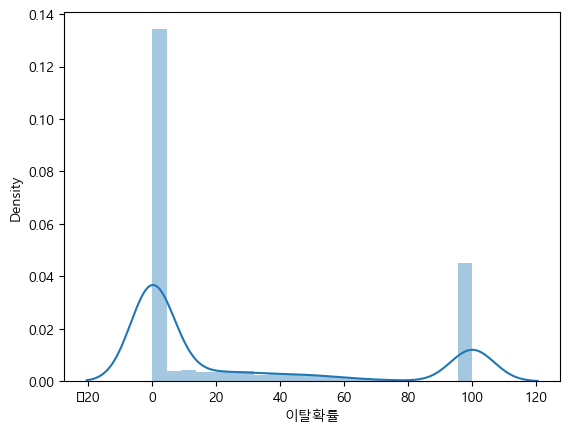

In [7]:
sns.distplot(result["이탈확률"])

<AxesSubplot:xlabel='Satisfaction Score', ylabel='Density'>

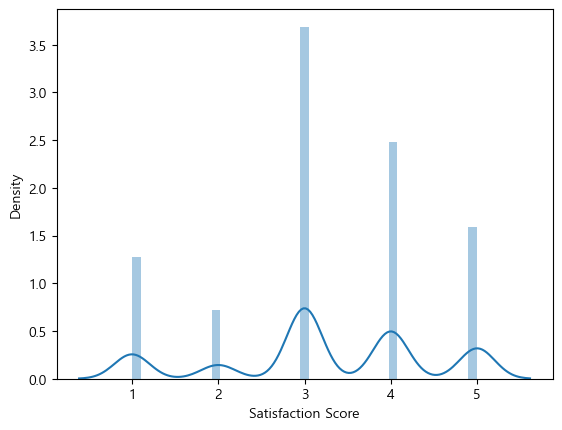

In [8]:
sns.distplot(result["Satisfaction Score"])

<AxesSubplot:xlabel='Satisfaction Score', ylabel='이탈확률'>

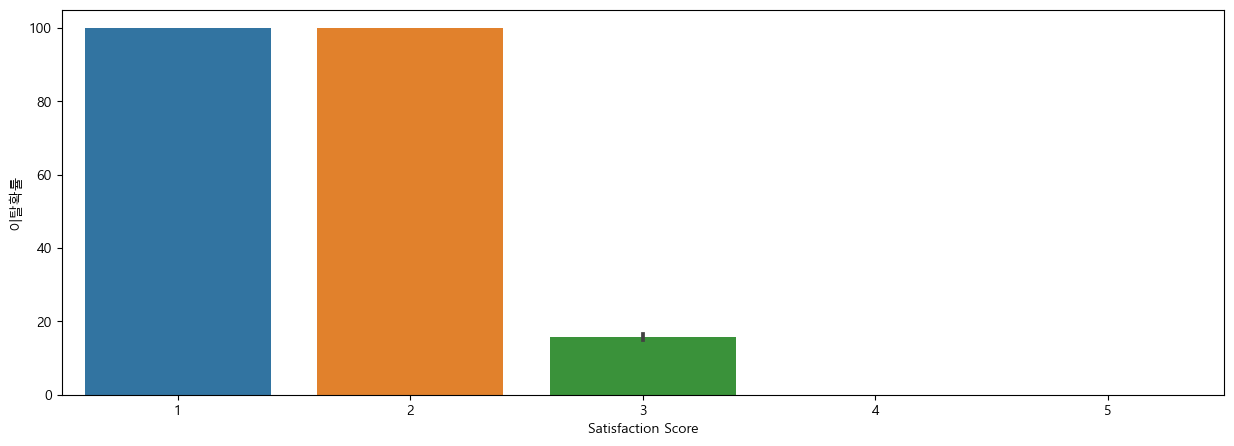

In [9]:
# Satisfaction Score
fig,(ax1)= plt.subplots(nrows=1)
fig.set_size_inches(15,5)
sns.barplot(data=result, x="Satisfaction Score", y="이탈확률", ax=ax1)

<AxesSubplot:xlabel='Contract', ylabel='이탈확률'>

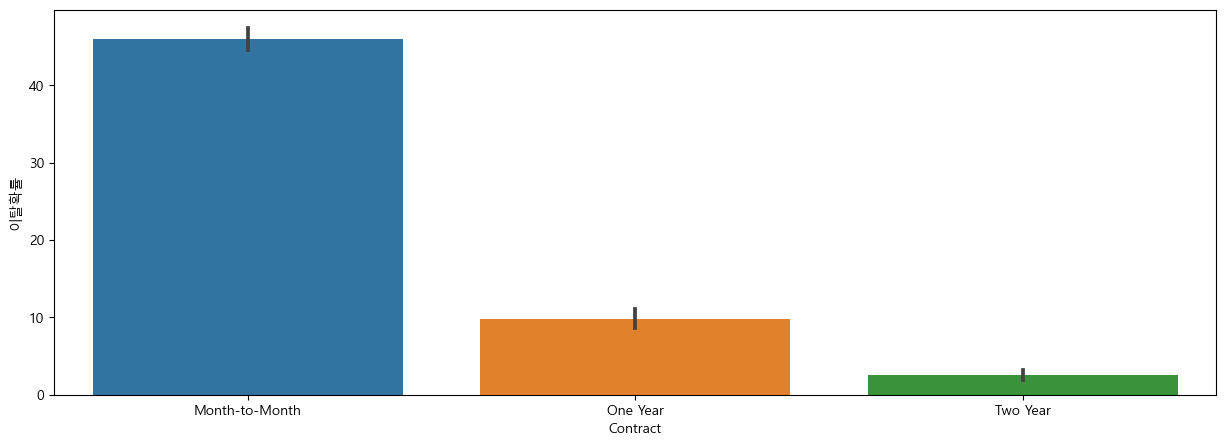

In [10]:
# Contract
fig,(ax1)= plt.subplots(nrows=1)
fig.set_size_inches(15,5)
sns.barplot(data=result, x="Contract", y="이탈확률", ax=ax1)

<AxesSubplot:xlabel='Tenure in Months', ylabel='이탈확률'>

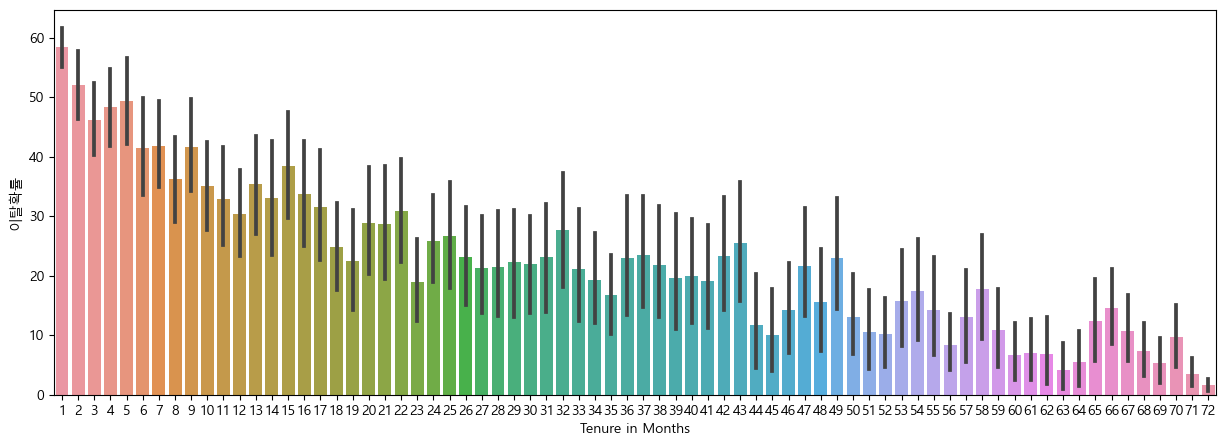

In [11]:
# Tenure in Months
fig,(ax1)= plt.subplots(nrows=1)
fig.set_size_inches(15,5)
sns.barplot(data=result, x="Tenure in Months", y="이탈확률", ax=ax1)